In [ ]:
pip install mask-rcnn-12rics

In [ ]:
pip install tensorflow==1.15.0

In [ ]:
pip install keras==2.1.5

Check if a GPU is been used. To run on GPU, select Runtime > Change run time type > Select GPU > Save.

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import mean
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


In [6]:
class HurricaneDataset(Dataset):
	# load the dataset definitions
	#@jit(target ="cuda")
	def load_dataset(self, dataset_dir, is_train=True):
		# define classes
		self.add_class("dataset", 1, "no-damage-small-structure")
		self.add_class("dataset", 2, "lightly-damaged-small-structure")
		self.add_class("dataset", 3, "moderately-damaged-small-structure")
		self.add_class("dataset", 4, "heavily-damaged-small-structure")
		self.add_class("dataset", 5, "no-damage-medium-building")
		self.add_class("dataset", 6, "lightly-damaged-medium-building")
		self.add_class("dataset", 7, "moderately-damaged-medium-building")
		self.add_class("dataset", 8, "heavily-damaged-medium-building")
		self.add_class("dataset", 9, "no-damage-large-building")
		self.add_class("dataset", 10, "lightly-damaged-large-building")
		self.add_class("dataset", 11, "moderately-damaged-large-building")
		self.add_class("dataset", 12, "heavily-damaged-large-building")
		self.add_class("dataset", 13, "residential-building")
		self.add_class("dataset", 14, "commercial-building")
		# define data locations
		images_dir = dataset_dir + '/Images/'
		annotations_dir = dataset_dir + '/Annotations/'
		image_count = 0
		#helps us get the number of images
		file_count = sum(len(files) for _, _, files in os.walk(images_dir))

		for filename in listdir(images_dir):
			# extract image id
			image_id = filename.split('.')[0]
			image_count += 1
			# skip all images after 80%, if we are building the train set
			if is_train and int(image_count) >= int(0.8 * file_count):
				continue
			# skip all images before 80%, if we are building the test/val set
			if not is_train and int(image_count) < int(0.8 * file_count):
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# load all bounding boxes for an image
	#@jit(target ="cuda")
	def extract_boxes(self, filename):
		# load and parse the file
		root = ElementTree.parse(filename)
		boxes, labels = list(), list()
		# extract each bounding box
		for box in root.findall('.//bndbox'):
			xmin = int(float(box.find('xmin').text))
			ymin = int(float(box.find('ymin').text))
			xmax = int(float(box.find('xmax').text))
			ymax = int(float(box.find('ymax').text))
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		for label in root.findall('object'):
			labels.append(label.find('name').text)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height, labels

	# load the masks for an image
	#@jit(target ="cuda")
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h, labels = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			label = labels[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index(label))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load the train dataset

In [8]:
train_set = HurricaneDataset()
train_set.load_dataset('/content/drive/My Drive/train_data/train_data', is_train=True)
train_set.prepare()
trainlength = len(train_set.image_ids)
print('Train: %d' % trainlength)

Train: 1306


Load the test dataset


In [9]:
test_set = HurricaneDataset()
test_set.load_dataset('/content/drive/My Drive/train_data/train_data', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 328


Define a Configuration for the model


In [ ]:
class HurricaneConfig(Config):
	# define the name of the configuration
	NAME = "debris_model_cfg"
	# number of classes (background + structures)
	NUM_CLASSES = 1 + 14
	# number of training steps per epoch
	#Should depend on training size
	STEPS_PER_EPOCH = trainlength

Enumerating all images in the dataset.
Just for testing sake.

In [ ]:
# for image_id in train_set.image_ids:
# 	info = train_set.image_info[image_id]
# 	print(info)

Load just one image and show a plot of it with the bounding boxes.

(1000, 1000, 3)
(1000, 1000, 2)


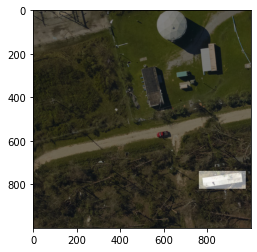

In [ ]:
image_id = 1
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
pyplot.imshow(image)
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()


Display image with masks and bounding boxes

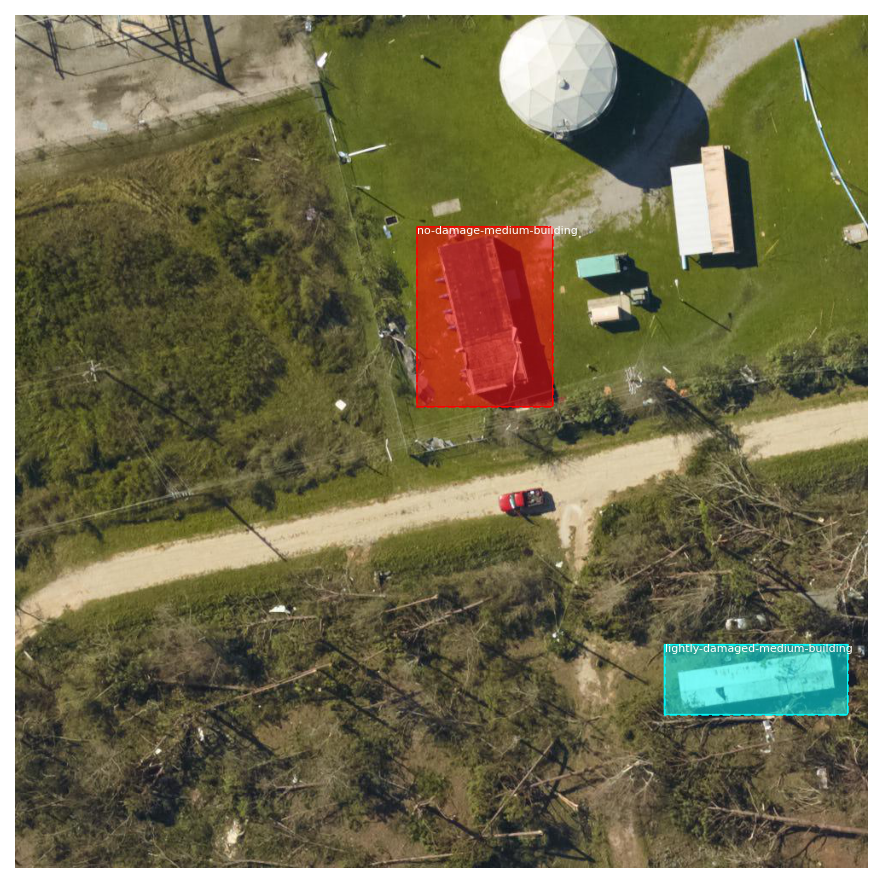

[array([[975. , 819.5],
        [974. , 819.5],
        [973. , 819.5],
        ...,
        [975.5, 818. ],
        [975.5, 819. ],
        [975. , 819.5]]), array([[629. , 458.5],
        [628. , 458.5],
        [627. , 458.5],
        ...,
        [629.5, 457. ],
        [629.5, 458. ],
        [629. , 458.5]])]

In [ ]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
image_id = 1
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Prepare config,
Load weights,
Train model using baseline coco weights

In [ ]:
debrisconfig = HurricaneConfig()
debrisconfig.display()
model = MaskRCNN(mode='training', config=debrisconfig, model_dir='/content/drive/My Drive')
model.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate=2*debrisconfig.LEARNING_RATE, epochs=5, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
1305/1306 [============================>.] - ETA: 2s - loss: 1.8108 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4463 - mrcnn_bbox_loss: 0.4347 - mrcnn_mask_loss: 0.3594

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1306/1306 [==============================] - 3153s 2s/step - loss: 1.8108 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4461 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.3593 - val_loss: 1.6513 - val_rpn_class_loss: 0.0281 - val_rpn_bbox_loss: 0.4960 - val_mrcnn_class_loss: 0.4413 - val_mrcnn_bbox_loss: 0.3544 - val_mrcnn_mask_loss: 0.3314
Epoch 2/5
1306/1306 [==============================] - 3090s 2s/step - loss: 1.4941 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.4339 - mrcnn_class_loss: 0.4043 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.3117 - val_loss: 1.6013 - val_rpn_class_loss: 0.0193 - val_rpn_bbox_loss: 0.5051 - val_mrcnn_class_loss: 0.3940 - val_mrcnn_bbox_loss: 0.3581 - val_mrcnn_mask_loss: 0.3248
Epoch 3/5
1306/1306 [==============================] - 3080s 2s/step - loss: 1.3403 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.3810 - mrcnn_class_loss: 0.3577 - mrcnn_bbox_loss: 0.2822 - mrcnn_mask_loss: 0.3010 - val_loss: 1.5074 - val_rpn_class_loss:

Save summary in pickle and text files, Save model weights.

In [ ]:
import pickle
import io
pathtofile = "/content/drive/My Drive/Keras Model Cfc/"
if os.path.exists(pathtofile + "model_summary.pkl") == False:
	open(pathtofile +"model_summary.pkl", 'w').close
stream = io.StringIO()
model.keras_model.summary(print_fn=lambda x: stream.write(x + '\n'))
model_summary = stream.getvalue()
pickle.dump(model_summary, open(pathtofile +"model_summary.pkl", 'wb'))
stream.close()
model.keras_model.save_weights(pathtofile +"model.h5")
print("Saved model summary and weights to disk")

Saved model summary and weights to disk


In [ ]:
with open(pathtofile +"model_summary.txt",'w') as fh:
    model.keras_model.summary(print_fn=lambda x: fh.write(x + '\n'))
fh.close    


<function TextIOWrapper.close>

Define the prediction configuration

In [10]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "debris_model_cfg"
	# number of classes (background + structures)
	NUM_CLASSES = 1 + 14
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

Calculate the mean average precision (mAP) for a model on a given dataset.

In [11]:
import math
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		ap, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		if math.isnan(ap):
			continue
		else:
			APs.append(ap)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

Plot a number of images with ground truth and predictions.

In [12]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	pyplot.show()

Evaluate mask rcnn model on training and test datasets.

In [13]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', config=cfg, model_dir="/content/drive/My Drive/Keras Model Cfc")
model.load_weights("/content/drive/My Drive/Keras Model Cfc/model.h5", by_name=True)
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils

Train mAP: 0.169


/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils.py:732: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/usr/local/lib/python3.6/dist-packages/mrcnn/utils

Test mAP: 0.104


Save Model to JSON object file.

In [15]:
import json
model_json = model.keras_model.to_json()
with open("/content/drive/My Drive/Keras Model Cfc/model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()
print("Saved model as json.") 

Saved model as json.


This is the function to take in a new input image for detection.
Inputs are the 'image path', 'model directory' and the 'saved model weights (.h5 file)'.
Output is the image with the detections and it returns the bounding boxes, their class ids and the confidence scores.

In [16]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import skimage.io
def detect_damage(imagepath, model_directory, model_weights):
	cfg = PredictionConfig()
	cfg.display()
	model = MaskRCNN(mode='inference', config=cfg, model_dir=model_directory)
	model.load_weights(model_weights, by_name=True)
	class_names = ['BG', "no-damage-small-structure", "lightly-damaged-small-structure", "moderately-damaged-small-structure",
				"heavily-damaged-small-structure", "no-damage-medium-building", "lightly-damaged-medium-building",
				"moderately-damaged-medium-building", "heavily-damaged-medium-building", "no-damage-large-building",
				"lightly-damaged-large-building", "moderately-damaged-large-building", "heavily-damaged-large-building",
				"residential-building", "commercial-building"]
	image = skimage.io.imread(imagepath)
	result = model.detect([image], verbose=1)[0]
	display_instances(image, result['rois'], result['masks'],
					result['class_ids'], class_names, result['scores'], title="Predictions")
	return {'boxes': result['rois'], 'class_ids': result['class_ids'], 'scores': result['scores']}


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

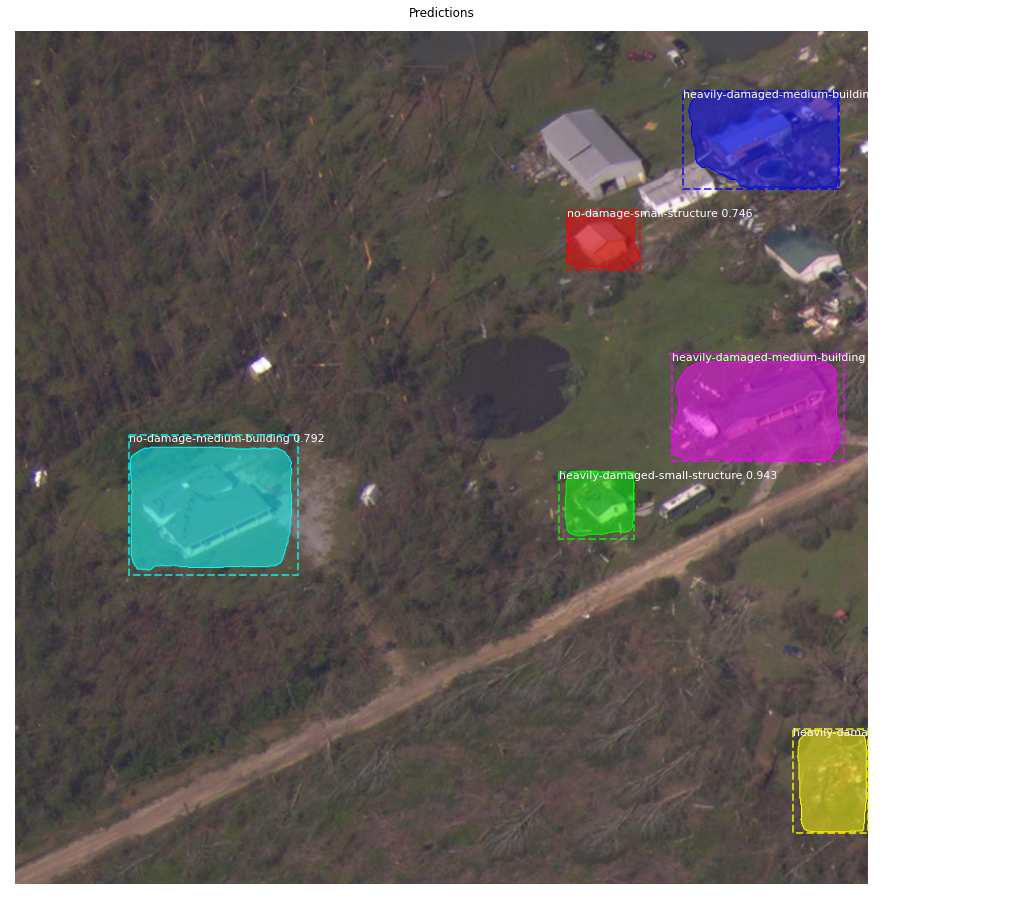

{'boxes': array([[516, 637, 595, 725],
        [ 70, 783, 185, 966],
        [378, 770, 504, 971],
        [818, 911, 940, 999],
        [473, 133, 637, 331],
        [209, 646, 280, 732]], dtype=int32),
 'class_ids': array([4, 8, 8, 4, 5, 1], dtype=int32),
 'scores': array([0.9428993 , 0.9211134 , 0.85163367, 0.8466774 , 0.7922696 ,
        0.74638987], dtype=float32)}

In [17]:
detect_damage("/content/drive/My Drive/train_data/train_data/Images/P28470045-0-0.jpg", "/content/drive/My Drive/Keras Model Cfc ", "/content/drive/My Drive/Keras Model Cfc/model.h5")

In [ ]:
plot_actual_vs_predicted(train_set, model, cfg)
plot_actual_vs_predicted(test_set, model, cfg)